In [1]:
import configparser
import jax.numpy as jnp
from jax import jit, grad, vmap
from jax import random, lax, tree_util
import jax
from functools import partial
from einops import rearrange

from jax import Array
from jax.typing import ArrayLike


# Simulation Code

In [2]:
def compute_phase_field(f, **kwargs):
    return jnp.einsum("kij->ij", f)

In [3]:
@jit
@partial(vmap, in_axes=(None, None, None, 0, None, None), out_axes=0)
def _eq_dist(cXYs, weights, phi_weights, k, pressure, u):
    cu = jnp.sum(u * cXYs[k])
    u2 = jnp.sum(jnp.square(u))

    def equi_0(k, phi_weights, weights, pressure, u2, cu):
        return phi_weights[0] * (1 - weights[0]) * 3.0 * pressure - weights[0] * u2 * 1.5

    def equi_k(k, phi_weights, weights, pressure, u2, cu):
        return phi_weights[k] * weights[k] * 3.0 * pressure - weights[k] * (1.5 * u2 + 3.0 * cu + 4.5 * cu * cu)

    return lax.cond(k == 0,
                    equi_0,
                    equi_k,
                    k, phi_weights, weights, pressure, u2, cu)

__eq_dist = vmap(_eq_dist, in_axes=(None, None, None, None, 0, 0), out_axes=1)
eq_dist = vmap(__eq_dist, in_axes=(None, None, None, None, 0, 0), out_axes=1)

In [4]:
@jit
@partial(vmap, in_axes=(None, None, 0, 0), out_axes=1)
@partial(vmap, in_axes=(None, None, 0, 0), out_axes=1)
# @partial(vmap, in_axes=(None, None, 0, None, None), out_axes=0)
# @chex.assert_max_traces(n=1)
def eq_dist_phase_field(cXYs, weights, phi, u):
    cu = jnp.sum(u * cXYs)
    u2 = jnp.sum(jnp.square(u))
    return weights * phi * (1.0 - 1.5 * u2 + 3.0 * cu + 4.5 * cu * cu)

## Density and Velocity update

### Notes about the functions

1. Every function is pure without side effects
2. They work for a single grid point
3. These functions will be vectorized to map over the entire grid


In [5]:
def compute_dst_phase_field(cXs, cYs, phase_field, **kwargs):
    dst_phase_field = []

    for i, cx, cy in zip(jnp.arange(9), cXs, cYs):
        dst_phase_field.append(
            jnp.roll(phase_field, (-cx, -cy), axis=(0, 1)))

    return jnp.stack(dst_phase_field)
# rearrange(, "k i j -> i j k") #.transpose(1, 2, 0)

In [6]:
@jit
@partial(vmap, in_axes=(None, None, 1), out_axes=0)
@partial(vmap, in_axes=(None, None, 1), out_axes=0)
def compute_phi_grad(cXYs, weights, dst_phase_field, **kwargs):
    phi_grad = 3 * jnp.einsum("k,k,kx->x", weights, dst_phase_field, cXYs)

    return phi_grad

In [7]:
@jit
@partial(vmap, in_axes=(None, None, None, 0, 1, 0), out_axes=0)
@partial(vmap, in_axes=(None, None, None, 0, 1, 0), out_axes=0)
def surface_tension_force(surface_tension, width, weights, phase_field, dst_phase_field, phi_grad):
    phase_diff = dst_phase_field - phase_field
    laplacian_loc = 6 * jnp.einsum("k,k", phase_diff, weights)

    phase_term = (48 * phase_field * (1 - phase_field) * (0.5 - phase_field)) / width 
    phase_term -= (1.5 * width * laplacian_loc)

    curvature_force = surface_tension * phase_term * phi_grad #jnp.einsum(",vij->vij", phase_term, phi_grad)

    return curvature_force

In [8]:
@jit
@partial(vmap, in_axes=(None, None, None, 0, 0, 0, 1), out_axes=0)
@partial(vmap, in_axes=(None, None, None, 0, 0, 0, 1), out_axes=0)
def compute_mom(
    kin_visc_one,
    kin_visc_two,
    M_D2Q9,
    u,
    pressure,
    phase_field,
    N):
    alpha = 4.0 / 9.0
    u2 = u[0] * u[0] + u[1] * u[1]
    mom_eq = jnp.array([1.0,
                        -(2 + 18 * alpha) / 5.0 + 3.0 * (u2 + 2 * pressure),
                        (-7.0 + 27 * alpha) / 5 - 3.0 * (u2 + 3 * pressure),
                        u[0],
                        -u[0],
                        u[1],
                        -u[1],
                        u[0] * u[0] - u[1] * u[1],
                        u[0] * u[1]])

    inv_kin_visc = (phase_field / kin_visc_one) + \
        (1 - phase_field) / kin_visc_two
    kin_visc_local = 1 / inv_kin_visc

    mom = jnp.einsum('kl,l->k', M_D2Q9, N)

    return mom, mom_eq, kin_visc_local

In [9]:
@jit
@partial(vmap, in_axes=(None, None, None, None, None, None, 0, 0, 0, 0), out_axes=0)
@partial(vmap, in_axes=(None, None, None, None, None, None, 0, 0, 0, 0), out_axes=0)
def compute_viscosity_correction(
    kin_visc_one,
    kin_visc_two,
    invM_D2Q9,
    cMs,
    density_one,
    density_two,
    phi_grad,
    kin_visc_local,
    mom,
    mom_eq):
    
    tauL = 0.5 + 3 * kin_visc_local
    
    S_D2Q9 = jnp.ones(9)
    S_D2Q9 = S_D2Q9.at[7].set(1.0 / tauL)
    S_D2Q9 = S_D2Q9.at[8].set(1.0 / tauL)
    
    mom_diff = jnp.einsum(
        'kl,l,l->k', invM_D2Q9, S_D2Q9, (mom - mom_eq))
    
    viscous_force = -3.0 * kin_visc_local * \
        (density_one - density_two) * \
        jnp.einsum('kmn, k, n -> m',  cMs, mom_diff, phi_grad)

    return viscous_force

In [10]:
@jit
@partial(vmap, in_axes=(None, None, 0, 0, 0), out_axes=0)
@partial(vmap, in_axes=(None, None, 0, 0, 0), out_axes=0)
def compute_total_force(
    gravityX,
    gravityY,
    curvature_force,
    viscous_force,
    rho):
    rest_force = jnp.stack([rho* gravityX, rho * gravityY])
    return rest_force + curvature_force + viscous_force

In [11]:
# TODO: Recheck this function
@jit
@partial(vmap, in_axes=(None, None, None, None, 0, 0, 0, 1, 0), out_axes=0)
@partial(vmap, in_axes=(None, None, None, None, 0, 0, 0, 1, 0), out_axes=0)
def compute_density_velocity_pressure(
    density_one,
    density_two,
    weights,
    phi_weights,
    pressure,
    phase_field,
    phi_grad,
    N,
    total_force):
    
    # This function is supposed to happen when obstacle != 1
    
    sumNX = jnp.dot(N, cXs)
    sumNY = jnp.dot(N, cYs)
    sumNV = jnp.stack([sumNX, sumNY])
    
    sumN = jnp.sum(N)
    
    rho = density_one * phase_field + \
        density_two * (1 - phase_field)
    
    # TODO: There was a for loop here is it really needed?
    u = sumNV + total_force - (pressure * (density_one - density_two) * phi_grad) / rho
    usq = jnp.sum(jnp.square(u))
    
    pressure = (sumN / 3.0 - weights[0] * usq * 0.5 - (1 - phi_weights[0]) / 3.0) / (1 - weights[0])
    
    interface_force = total_force - pressure * (density_one - density_two) * phi_grad
    
    return rho, u, pressure, interface_force

## Collision

In [12]:
@jit
@partial(vmap, in_axes=(None, 0, 0, 0, 0, 0, 0, 1), out_axes=1)
@partial(vmap, in_axes=(None, 0, 0, 0, 0, 0, 0, 1), out_axes=1)
def compute_collision(
    invM_D2Q9,
    obs,
    mom,
    mom_eq,
    kin_visc_local,
    interface_force,
    rho,
    N 
):
    # TODO: For collision the u, pressure, rho are are supposed to be taken after
    # the compute_density_velocity_pressure
    tauL = 0.5 + 3 * kin_visc_local

    S_D2Q9 = jnp.ones(9)
    S_D2Q9 = S_D2Q9.at[7].set(1.0 / tauL)
    S_D2Q9 = S_D2Q9.at[8].set(1.0 / tauL)

    force = interface_force / rho

    force_eq = jnp.zeros(9)
    force_eq = force_eq.at[3].set(force[0])
    force_eq = force_eq.at[4].set(-force[0])
    force_eq = force_eq.at[5].set(force[1])
    force_eq = force_eq.at[6].set(-force[1])

    mom_diff = mom - S_D2Q9 * (mom - mom_eq) + (force_eq - 0.5 * S_D2Q9 * force_eq)
    N_new = jnp.einsum("kl,l->k", invM_D2Q9, mom_diff)
    
    # We will have to compute this to avoid divergence
    return lax.select(obs, N_new[np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])], N_new)

In [13]:
@jit
@partial(vmap, in_axes=(None, None, None, None, 0, 0, 0, 0, 0, 1), out_axes=1)
@partial(vmap, in_axes=(None, None, None, None, 0, 0, 0, 0, 0, 1), out_axes=1)
def compute_segregation(
    width,
    cXYs,
    weights,
    phi_weights,
    phase_field,
    phi_grad,
    pressure,
    rho,
    u,
    N_new
):
    phi_mag = jnp.sqrt(jnp.sum(jnp.square(phi_grad)))
    
    # (phigrad_dot_c / phi_mag) is nan for non interface region
    
    # [k]
    N_eq = _eq_dist(cXYs, weights, phi_weights, jnp.arange(9), pressure, u)
    # 9, 2
    phigrad_dot_c = jnp.sum(phi_grad * cXYs, axis=1)
    seg_term = (2.0 / width) * (1.0 - phase_field) * phase_field * (phigrad_dot_c / phi_mag) * N_eq
    
    f_new = phase_field * N_new + seg_term
    return f_new

In [14]:
@partial(vmap, in_axes=(None, None, None, 0, 0, 1, 1, 1, 1), out_axes=1)
@partial(vmap, in_axes=(None, None, None, 0, 0, 1, 1, 1, 1), out_axes=1)
def handle_obstacle(cXs, cYs, weights, obs, obsVel, f_new, f_new_dst, N_new, N_new_dst):
    N_invert = N_new[np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])] * 6.0 * weights * (cXs * obsVel[0] + cYs * obsVel[1])
    f_invert = f_new[np.array([0, 3, 4, 1, 2, 7, 8, 5, 6])]
    
    f = lax.select(obs, f_invert, f_new_dst)
    N = lax.select(obs, N_invert, N_new_dst)
    return N, f

In [15]:
@jit
def compute_propagation(cXs, cYs, weights, obs, obsVel, N_new, f_new):
    N = []
    f = []
    for i, cx, cy in zip(jnp.arange(9), cXs, cYs):
        N.append(jnp.roll(N_new[i], (-cx, -cy), axis=(0, 1)))
        f.append(jnp.roll(f_new[i], (-cx, -cy), axis=(0, 1)))

    N_dst = jnp.stack(N)
    f_dst = jnp.stack(f)
    
    return handle_obstacle(cXs, cYs, weights, obs, obsVel, f_new, f_dst, N_new, N_dst)

# Simulation Loop

In [16]:
@jit
def simulation_step(state, idx):
    # [i,j,k]
    phase_field = compute_phase_field(**state)
    dst_phase_field = compute_dst_phase_field(phase_field=phase_field, **state)
    
    # VMapped functions
    
    phi_grad = compute_phi_grad(state["cXYs"], state["weights"], dst_phase_field)
    
    curvature_force = surface_tension_force(
        state["surface_tension"],
        state["width"],
        state["weights"],
        phase_field,
        dst_phase_field,
        phi_grad)

    mom, mom_eq, kin_visc_local = compute_mom(
        state["kin_visc_one"],
        state["kin_visc_two"],
        state["M_D2Q9"],
        state["u"],
        state["pressure"],
        phase_field,
        state["N"])
    
    viscous_force = compute_viscosity_correction(
        state["kin_visc_one"],
        state["kin_visc_two"],
        state["invM_D2Q9"],
        state["cMs"],
        state["density_one"],
        state["density_two"],
        phi_grad,
        kin_visc_local,
        mom,
        mom_eq)

    total_force = compute_total_force(
        state["gravityX"],
        state["gravityY"],
        curvature_force,
        viscous_force,
        state["rho"]
    )
    
    rho, u, pressure, interface_force = compute_density_velocity_pressure(
        state["density_one"],
        state["density_two"],
        state["weights"],
        state["phi_weights"],
        state["pressure"],
        phase_field,
        phi_grad,
        state["N"],
        total_force
    )
    
    N_new = compute_collision(
        state["invM_D2Q9"],
        state["obs"],
        mom,
        mom_eq,
        kin_visc_local,
        interface_force,
        state["rho"],
        state["N"]
    )
    
        
    f_new = compute_segregation(
        state["width"],
        state["cXYs"],
        state["weights"],
        state["phi_weights"],
        phase_field,
        phi_grad,
        pressure,
        rho,
        u,
        N_new
    )
    
    N, f = compute_propagation(
        state["cXs"],
        state["cYs"],
        state["weights"],
        state["obs"],
        state["obs_vel"],
        N_new,
        f_new
    )
    
#     jax.debug.print(f"Nshape {N.shape}")

    new_state = {
        **state,
        "u": u,
        "pressure": pressure,
        "rho": rho,
        "N": N,
        "f": f
    }
    return new_state

In [17]:
# st_2 = simulation_step(state, 1)
# simulation_step(st_2, 2)

In [18]:
@jit
def multi_step_simulation_block(state, nr_iter):
    return lax.fori_loop(0, nr_iter, lambda i, s: simulation_step(s, i), state)

In [19]:
import numpy as np
# We need numpy here where we transfer data from the GPU

# Note: There needs to be a separate function for calling
# multi_step_simulation_block so that we can shard and perform pmap later
def multi_step_simulation(state, nr_iter, save_interval=200):

    results = [{
        "u": state["u"]
#         "N": state["N"]
    }]

    for _ in range(nr_iter // save_interval):
        state = multi_step_simulation_block(state, save_interval)
        results.append({
            "u": state["u"]
#             "N": state["N"]
        })
    # Receive the buffer from the Accelerator
    results = jax.device_get(results)
    return tree_util.tree_map(
        lambda *rs: np.stack([np.array(r) for r in rs]),
        *results)

# Simulation Parameters


In [20]:
beta = 9
alpha = 4.0 / 9.0


class SimParams:
    def __init__(self, config_file):
        self.parse_params(config_file)

    def parse_params(self, config_file):
        config = configparser.ConfigParser()
        config.read(config_file)
        pt = config["Simulation"]

        # We could destructure into a map
        self.LX = int(pt.get("LX", 0))
        self.LY = int(pt.get("LY", 0))
        self.NL = 9
        self.nr_iterations = int(pt.get("nr_iterations", 0))
        self.nr_samples = int(pt.get("nr_samples", 0))
        self.kin_visc_one = float(pt.get("kin_visc_one", 0.0))
        self.kin_visc_two = float(pt.get("kin_visc_two", 0.0))
        self.density_one = float(pt.get("density_one", 0.0))
        self.density_two = float(pt.get("density_two", 0.0))
        self.gravityX = float(pt.get("gravityX", 0.0))
        self.gravityY = float(pt.get("gravityY", 0.0))
        self.width = float(pt.get("width", 0.0))
        self.surface_tension = float(pt.get("surface_tension", 0.0))
        self.ref_pressure = float(pt.get("ref_pressure", 0.0))
        self.uWallX = float(pt.get("uWallX", 0.0))
        self.drop_radius = float(pt.get("drop_radius", 0.0))
        self.Width = 4.0

    def print_config(self):
        print(f"LX = {self.LX} LY= {self.LY}")
        print(
            f"nr_iterations = {self.nr_iterations}  nr_samples = {self.nr_samples}")
        print(f"kin_viscosities = {self.kin_visc_one} {self.kin_visc_two}")
        print(f"density = {self.density_one} {self.density_two}")
        print(f"gravity = {self.gravityX} {self.gravityY}")
        print(f"interface width = {self.width}")
        print(f"surface tension = {self.surface_tension}")
        print(f"reference pressure = {self.ref_pressure}")
        print(f"wall velocity = {self.uWallX}")
        print(f"drop radius = {self.drop_radius}")
        print(f"Width = {self.width}")

In [21]:
!cat params.ini

[Simulation]
LX = 100
LY = 100
nr_iterations = 2000
nr_samples = 100
kin_visc_one = 0.103
kin_visc_two = 0.103
density_one = 1
density_two = 1
gravityX = 1e-6
gravityY = 0.0
width = 4.0
surface_tension = 0.00412
ref_pressure = 0.1
uWallX = 0.1
drop_radius = 50
# beta = 9
# alpha = 4.0/9.0


In [22]:
config = SimParams("params.ini")
config.print_config()

LX = 100 LY= 100
nr_iterations = 2000  nr_samples = 100
kin_viscosities = 0.103 0.103
density = 1.0 1.0
gravity = 1e-06 0.0
interface width = 4.0
surface tension = 0.00412
reference pressure = 0.1
wall velocity = 0.1
drop radius = 50.0
Width = 4.0


# Initial conditions


In [23]:
LX = config.LX
LY = config.LY
NL = config.NL

density_one = config.density_one
density_two = config.density_two

grid_shape = (LY, LX)
alpha = 4.0 / 9.0

cXs = jnp.array([0, 1, 0, -1, 0, 1, -1, -1, 1], dtype=jnp.int32)
cYs = jnp.array([0, 0, 1, 0, -1, 1, 1, -1, -1], dtype=jnp.int32)
cXYs = jnp.array([(0.0, 0.0), (1.0, 0.0), (0.0, 1.0), (-1.0, 0.0), (0.0, -1.0),
                 (1.0, 1.0), (-1.0, 1.0), (-1.0, -1.0), (1.0, -1.0)])
cMs = jnp.einsum('ki,kj->kij', cXYs, cXYs)

weights = jnp.array([4.0 / 9.0,  1.0 / 9.0,  1.0 / 9.0,  1.0 / 9.0,
                     1.0 / 9.0, 1.0 / 36.0, 1.0 / 36.0, 1.0 / 36.0, 1.0 / 36.0])

phi_weights = jnp.array([alpha,
                         (1.0 - alpha) / 5.0,
                         (1.0 - alpha) / 5.0,
                         (1.0 - alpha) / 5.0,
                         (1.0 - alpha) / 5.0,
                         (1.0 - alpha) / 20.0,
                         (1.0 - alpha) / 20.0,
                         (1.0 - alpha) / 20.0,
                         (1.0 - alpha) / 20.0])

M_D2Q9 = jnp.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1],    [-4, -1, -1, -1, -
                                     1, 2, 2, 2, 2], [4, -2, -2, -2, -2, 1, 1, 1, 1],
    [0, 1, 0, -1, 0, 1, -1, -1, 1], [0, -2, 0, 2, 0,
                                     1, -1, -1, 1],   [0, 0, 1, 0, -1, 1, 1, -1, -1],
    [0, 0, -2, 0, 2, 1, 1, -1, -1], [0, 1, -1, 1, -1, 0, 0, 0, 0],    [0, 0, 0, 0, 0, 1, -1, 1, -1]])

invM_D2Q9 = jnp.array([
    [1 / 9.0, -(1 / 9.0), (1 / 9.0), 0, 0, 0, 0, 0, 0],
    [1 / 9.0, -(1 / 36.0), -(1 / 18.0), (1 / 6.0), -
     (1 / 6.0), 0, 0, 1 / 4.0, 0],
    [1 / 9.0, -(1 / 36.0), -(1 / 18.0), 0, 0, 1 /
     6.0, -(1 / 6.0), -(1 / 4.0), 0],
    [1 / 9.0, -(1 / 36.0), -(1 / 18.0), -(1 / 6.0), 1 / 6.0, 0, 0, 1 / 4.0, 0],
    [1 / 9.0, -(1 / 36.0), -(1 / 18.0), 0, 0, -
     (1 / 6.0), 1 / 6.0, -(1 / 4.0), 0],
    [1 / 9.0, 1 / 18.0, 1 / 36.0, 1 / 6.0, 1 / 12.0, 1 / 6.0, 1 / 12.0, 0, 1 / 4.0],
    [1 / 9.0, 1 / 18.0, 1 / 36.0, -
        (1 / 6.0), -(1 / 12.0), 1 / 6.0, 1 / 12.0, 0, -(1 / 4.0)],
    [1 / 9.0, 1 / 18.0, 1 / 36.0, -
        (1 / 6.0), -(1 / 12.0), -(1 / 6.0), -(1 / 12.0), 0, 1 / 4.0],
    [1 / 9.0, 1 / 18.0, 1 / 36.0, 1 / 6.0, 1 / 12.0, -(1 / 6.0), -(1 / 12.0), 0, -(1 / 4.0)]])

## Phase Field

In [24]:
phase_field = jnp.zeros(grid_shape)

center = (LX/2, LY/2)
radius = LY/4
X, Y = jnp.meshgrid(jnp.arange(LX), jnp.arange(LY))


### Initialising drop

drop = (X - center[0]) ** 2 + (Y - center[1]) ** 2 < radius ** 2

phase_field = phase_field.at[drop].set(1.0)

### Initialising drop with tanh

In [25]:
#### change to code when running
distanceFromCenter = jnp.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)

phase_field = 1.0 + jnp.tanh((distanceFromCenter - radius) * 2.0 / config.width)

### Initialising square drop

#### change to code when running
side = min(LX, LY) / 2

square = jnp.logical_and(abs(X - center[0]) < side/2, abs(Y - center[1]) < side / 2)
phase_field = phase_field.at[square].set(1.0)

## Density, Velocity, Pressure

In [26]:
rho = density_one * phase_field + density_two * (1.0 - phase_field)
pressure = jnp.full(grid_shape, config.ref_pressure)

u_x = -config.uWallX + (Y - 2.5) * 2 * config.uWallX / (LY - 6)
u_y = jnp.zeros(grid_shape)
u = rearrange(jnp.stack([u_x, u_y]), "x i j -> i j x") #.transpose(1, 2, 0)

## Obstacle

In [27]:
obs = jnp.zeros(grid_shape, dtype=bool)
obs_velX = jnp.zeros(grid_shape)
obs_velY = jnp.zeros(grid_shape)

cylinder = (X - center[0]) ** 2 + (Y - center[1]) ** 2 < radius ** 2
obs = obs.at[cylinder].set(1.0)
obs_velX = obs_velX.at[cylinder].set(config.uWallX)
obs_velY = obs_velY.at[cylinder].set(config.uWallX)

obs_vel = rearrange(jnp.stack([obs_velX, obs_velY]), "x i j -> i j x")

# TODO: Find another way to set the obstacle
# for i in range(config.LX):
#     obs = obs.at[i, [0, 1, 2, -3, -2, -1]].set(True)
#     obs_velX = obs_velX.at[i, [-3, -2, -1]].set(config.uWallX)
#     obs_velX = obs_velX.at[i, [0, 1, 2]].set(-config.uWallX)

/home/nimalan/miniconda3/envs/ml/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [28]:
f = eq_dist_phase_field(cXYs, weights, phase_field, jnp.zeros((LX, LY, 2)))
N = eq_dist(cXYs, weights, phi_weights, jnp.arange(9), pressure, jnp.zeros((LX, LY, 2)))

# cxs, cys, weights, k, phi, ux, uy)

In [29]:
# We could nest the pytree in JAX
state = {
    "LX": LX,
    "LY": LY,
    "NL": NL,

    # Scalar Constants
    "kin_visc_one": config.kin_visc_one,
    "kin_visc_two": config.kin_visc_two,
    "density_one": config.density_one,
    "density_two": config.density_two,
    "gravityX": config.gravityX,
    "gravityY": config.gravityY,
    "width": config.width,
    "surface_tension": config.surface_tension,
    "ref_pressure": config.ref_pressure,
    "uWallX": config.uWallX,
    "drop_radius": config.drop_radius,
    "alpha": alpha,

    # N-D Constants
    # [k]
    "cXs": cXs,
    "cYs": cYs,
    # TODO: check if cXYs is needed
    "cXYs": cXYs,
    "cMs": cMs,
    "weights": weights,
    "phi_weights": phi_weights,
    "M_D2Q9": M_D2Q9,
    "invM_D2Q9": invM_D2Q9,

    # Tensors
    # [ij]
#     "phase_field": phase_field,
    "rho": rho,
    "pressure": pressure,
    "u": u,
    "obs": obs,
    "obs_vel": obs_vel,

    # [ijk]
    "f": f,
    "N": N
}

# Simulation

In [30]:
nr_iter = 10
nr_snapshot = 10
nr_snapshot_iter = nr_iter // nr_snapshot
final_step = multi_step_simulation(state, nr_iter, nr_snapshot_iter)

In [31]:
%timeit multi_step_simulation(state, 1000, 100)

274 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Visualization

In [32]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import skimage.filters

ux_final, uy_final = rearrange(final_step["u"], "t i y x -> x t i y")#.transpose(3, 0, 1, 2)

# ux_final[:,obstacle] = 0
# uy_final[:,obstacle] = 0
vorticity = (
    np.roll(ux_final, -1, axis=1) - np.roll(ux_final, 1, axis=1)
) - (
    np.roll(uy_final, -1, axis=2) - np.roll(uy_final, 1, axis=2))

## Quiver Plot

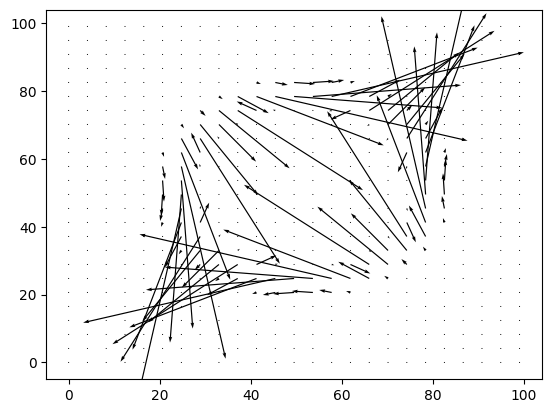

In [33]:
szx = LX
szy = LY
timestep = 1

# Plotting all the arrows will be messy so we are sampling one in every 16 points
skip = 4
x = np.linspace(0,szx-1,szx//skip)
y = np.linspace(0,szy-1,szy//skip)

u = ux_final[timestep][:szx:skip,:szx:skip]
v = uy_final[timestep][:szy:skip,:szy:skip]

plt.quiver(x, y, u, v)

## Vorticity

0.018895548


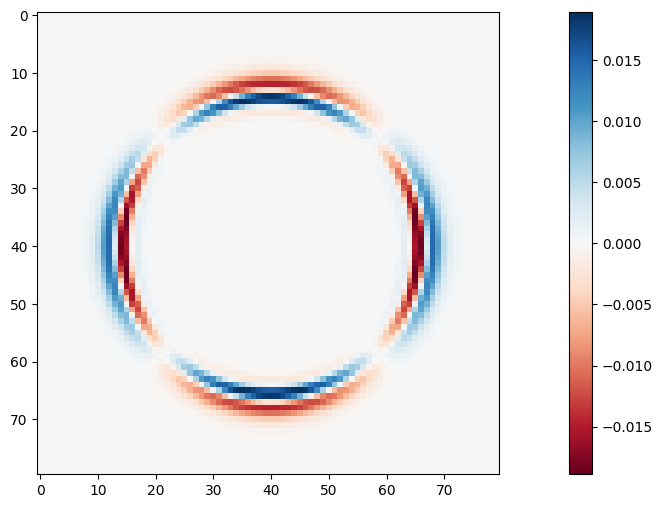

In [34]:
plt.figure(figsize=(18, 6))

frame = vorticity[1]

this_vmax = np.max(abs(frame))

print(this_vmax)

norm = clr.Normalize(vmin=-this_vmax, vmax=this_vmax)

# plt.axis('off')
plt.imshow(frame[10:-10, 10:-10], cmap='RdBu', norm=norm);
plt.colorbar()
# plt.clim(-.001, .001)

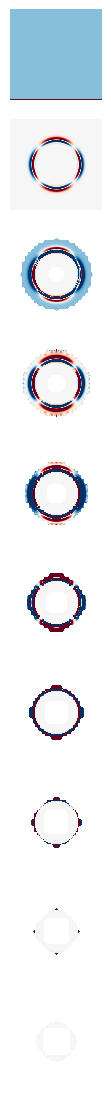

In [35]:
n = 10
samples = 100
fig, axes = plt.subplots(n, 1, figsize=(14, 14))
[ax.axis('off') for ax in axes]

# axes[0].cmap
# fig.colorbar()
axes[0].imshow(vorticity[0], cmap='RdBu', vmin=-0.01, vmax=0.01)
for i in range(min(n-1, len(vorticity)-1)):
    axes[i+1].imshow(vorticity[i + 1], cmap='RdBu', vmin=-0.01, vmax=0.01)

In [36]:
import matplotlib.cm
import matplotlib.colors
from PIL import Image

def make_images(data, cmap='RdBu', vmax=None):
    images = []
    for frame in data:
        if vmax is None:
            this_vmax = np.max(abs(frame))
        else:
            this_vmax = vmax
        norm = matplotlib.colors.Normalize(vmin=-this_vmax, vmax=this_vmax)
        mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
        rgba = mappable.to_rgba(frame, bytes=True)
        image = Image.fromarray(rgba, mode='RGBA')
        images.append(image)
    return images

def save_movie(images, path, duration=100, loop=0, **kwargs):
    images[0].save(path, save_all=True, append_images=images[1:],
                 duration=duration, loop=loop, **kwargs)

images = make_images(vorticity, vmax=0.0001)


In [37]:
from functools import partial
import proglog
import skimage.filters
from moviepy.editor import ImageSequenceClip

# Show Movie
proglog.default_bar_logger = partial(proglog.default_bar_logger, None)
ImageSequenceClip([np.array(im) for im in images], fps=2).ipython_display()

In [38]:
# save_movie(images,'wave_movie.gif', duration=[2000]+[200]*(len(images)-2)+[2000])